In [1]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,  roc_curve, auc

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#classifiers
#from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

#for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = 'SMSSpamData.csv'
df = pd.read_csv(filename) 

In [3]:
#change labels from spam and ham to 1 and 0
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['class']))}

print(class_mapping)
class_labels = [x for x in class_mapping] # store the class labels for later
df["class"] = df["class"].map(class_mapping)
df.head(3)

{'ham': 0, 'spam': 1}


,class,sms_msg
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Matt
[nltk_data]     Christie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    #convert all to lowercase
    # remove nose char for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text


df['sms_msg'] = df['sms_msg'].apply(preprocessor)


def tokenizer(text):
       return text.split()

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]#text.split()]
def stop_removal(text):
       return [w for w in text if not w in stop]

In [6]:
df.loc[180, 'sms_msg']

'hi you just spoke to maneesha v we d like to know if you were satisfied with the experience reply toll free with yes or no '

In [16]:
param_grid = [{'tfidfvectorizer__ngram_range': [(1, 1)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
               'tfidfvectorizer__stop_words': [stop, None], # use the stop dictionary of stopwords or not
               'tfidfvectorizer__max_features': [1000, 4000], # use the stop dictionary of stopwords or not
               'tfidfvectorizer__tokenizer': [tokenizer_stemmer]}, # use a tokeniser and the stemmer 
              ]

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        min_df=7,
                        preprocessor=None)

# k-Nearest Neighbors

In [21]:
pipeline = make_pipeline(tfidf, KNeighborsClassifier(n_neighbors=10, weights ='distance'))

gs_tfidf = GridSearchCV(pipeline, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

# Naive Bayes

In [18]:
pipelineNB = make_pipeline(tfidf, MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None))

gs_tfidfNB = GridSearchCV(pipelineNB, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

# Multilayer Perceptron

In [19]:
pipelineMLP = make_pipeline(tfidf,MLPClassifier())

gs_tfidfMLP = GridSearchCV(pipelineMLP, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

In [20]:
X = df.loc[:, 'sms_msg'].values
y = df.loc[:, 'class'].values

text_train, text_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.25,
                                                          stratify=y)

#knn
print('KNN')
gs_tfidf.fit(text_train, y_train)
#NB
print('Naive Bayes')
gs_tfidfNB.fit(text_train, y_train)
#MLP
print('Multilayer Perceptron')
gs_tfidfMLP.fit(text_train, y_train)


KNN
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   36.0s finished


Naive Bayes
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   26.7s finished


Multilayer Perceptron
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=7,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'tfidfvectorizer__ngram_range': [(1, 1)], 'tfidfvectorizer__stop_words': [{'didn', 'doing', 'being', "should've", 'wasn', 'ours', "shan't", 'with', 'off', 'will', 'yours', 'nor', 'once', 't', 'all', 'their', 'are', 'then', 'so', 'does', 'other', 'those', "you'd", 'where', 'm', "aren't",...: [1000, 4000], 'tfidfvectorizer__tokenizer': [<function tokenizer_stemmer at 0x0000024FC08696A8>]}],
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [12]:
print('KNN')
print('Best parameter set: %s ' % gs_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_tfidf.best_score_)

KNN
Best parameter set: {'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': None, 'tfidfvectorizer__tokenizer': <function tokenizer_stemmer at 0x000001E96FC866A8>} 
CV Accuracy: 0.925


In [13]:
print('NB')
print('Best parameter set: %s ' % gs_tfidfNB.best_params_)
print('CV Accuracy: %.3f' % gs_tfidfNB.best_score_)

NB
Best parameter set: {'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': {'during', 'ourselves', 'an', 'while', 'between', 'both', 'wouldn', 'by', 'each', "didn't", 'hers', 'few', 'how', 'couldn', 'mustn', 'herself', 'some', 'wasn', 'into', 'does', 'did', 'should', "aren't", 'own', 'shouldn', 'when', 'now', 'yourselves', 'down', 't', 'will', "she's", 'any', 'because', "it's", 'above', "mustn't", "mightn't", "wasn't", 'himself', 'why', 'hasn', "you're", 'is', 'doesn', 'y', 'up', 'had', 'very', 'more', 'them', 'him', 'off', 'can', 'me', 've', "couldn't", "hasn't", 'as', "shouldn't", 'so', 'no', 'your', 'but', "wouldn't", 'mightn', "you'd", 's', "shan't", 'we', 'her', 'who', 'themselves', 'hadn', 'doing', 'after', 'which', 'theirs', 'i', 'am', "hadn't", 'these', 'you', 'all', "don't", 'until', 'myself', 'was', "that'll", 'my', 'yours', 'over', 'yourself', 'once', 'under', 'not', 'most', 'then', 'has', 'this', 'weren', 'needn', '

In [14]:
print('MLP')
print('Best parameter set: %s ' % gs_tfidfMLP.best_params_)
print('CV Accuracy: %.3f' % gs_tfidfMLP.best_score_)

MLP
Best parameter set: {'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': None, 'tfidfvectorizer__tokenizer': <function tokenizer_stemmer at 0x000001E96FC866A8>} 
CV Accuracy: 0.986


In [15]:
clf = gs_tfidf.best_estimator_
clfNB = gs_tfidfNB.best_estimator_
clfMLP = gs_tfidfMLP.best_estimator_

print('Test Accuracy For kNN: %.3f' % clf.score(text_test, y_test))
print('Test Accuracy For NB: %.3f' % clfNB.score(text_test, y_test))
print('Test Accuracy For MLP: %.3f' % clfMLP.score(text_test, y_test))

Test Accuracy For kNN: 0.940
Test Accuracy For NB: 0.984
Test Accuracy For MLP: 0.987


In [20]:
y_pred = clf.predict(text_test)
y_pred2 = clfNB.predict(text_test)
y_pred3 = clfMLP.predict(text_test)


y_test2 = pd.Series(y_test)
y_predKNN = pd.Series(y_pred)
y_predNB = pd.Series(y_pred2)
y_predMLP = pd.Series(y_pred3)

print('kNN')
print(pd.crosstab(y_test2, y_predKNN, rownames=['True'], colnames=['Predicted'], margins=True))
print('NB')
print(pd.crosstab(y_test2, y_predNB, rownames=['True'], colnames=['Predicted'], margins=True))
print('MLP')
print(pd.crosstab(y_test2, y_predMLP, rownames=['True'], colnames=['Predicted'], margins=True))


kNN
Predicted     0    1   All
True                      
0          1207    0  1207
1            83  104   187
All        1290  104  1394
NB
Predicted     0    1   All
True                      
0          1205    2  1207
1            21  166   187
All        1226  168  1394
MLP
Predicted     0    1   All
True                      
0          1202    5  1207
1            13  174   187
All        1215  179  1394


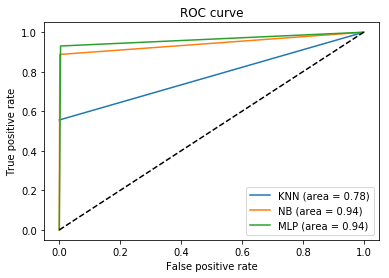

In [17]:
fpr1, tpr1, threshold1 = roc_curve(y_test, y_pred) 
fpr2, tpr2, threshold2 = roc_curve(y_test, y_pred2) 
fpr3, tpr3, threshold3 = roc_curve(y_test, y_pred3) 

# This is the AUC
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)
#auc = np.trapz(tpr1,fpr1)

# This is the ROC curve
plt.plot(fpr1,tpr1, label='KNN (area = %0.2f)' % (auc1))
plt.plot(fpr2,tpr2, label='NB (area = %0.2f)' % (auc2))
plt.plot(fpr3,tpr3, label='MLP (area = %0.2f)' % (auc2))
plt.plot([0, 1], [0, 1], 'k--') # diagonal

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show() 